# imports

In [1]:
import pickle
from srgnn_pl import SRGNN_model, SRGNN_Map_Dataset, SRGNN_sampler
from utils import fake_parser
import torch
import os

from torch.utils.data import DataLoader
import pytorch_lightning as pl

import numpy as np

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import pandas as pd
import yaml
from math import ceil
from sklearn.mixture import GaussianMixture
from IPython.display import clear_output

In [3]:
from matplotlib.pyplot import figure
from sklearn.manifold import TSNE
import plotly.graph_objects as go


In [4]:
torch.set_float32_matmul_precision('medium')

# data loading

In [5]:
run_id='run-20240404_162708-ekuo66ei'

#finetuned_run_id='run-20240302_233004-xh5dmcet'
global_run_id=run_id

In [6]:
with open(f"./wandb/{global_run_id}/files/config.yaml", "r") as stream:
        config=yaml.safe_load(stream)

keys=list(config.keys())
for k in keys:
    if k not in fake_parser().__dict__.keys():
        del config[k]
    else:
        config[k]=config[k]['value']

opt=fake_parser(**config)
print(opt.__dict__)

model=SRGNN_model.load_from_checkpoint(f"./GNN_master/{global_run_id.split('-')[-1]}/checkpoints/"+
                                       os.listdir(f"./GNN_master/{global_run_id.split('-')[-1]}/checkpoints/")[0], opt=opt)

{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 60, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 3, 'l2': 1e-05, 'step': 3, 'patience': 10, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.1, 'pretrained_embedings': False, 'unfreeze_epoch': 1}


In [8]:
test_data = pickle.load(open('../datasets/' + opt.dataset + '/test.txt', 'rb'))
test_dataset=SRGNN_Map_Dataset(test_data, shuffle=False)
test_dataloader=DataLoader(test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(test_dataset, opt.batchSize, shuffle=False, drop_last=False),
                             drop_last=False
                            )

data masking start


  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:00<00:00, 263.50it/s]

done masking


# Items data

In [9]:

if 'yoochoose' in opt.dataset:
    dfs=[]
    for k in trange(33003945//int(1e6)):
        df=pd.read_table('../datasets/yoochoose-clicks.dat', sep=',', dtype=str,
                        nrows=int(1e6), skiprows=k*int(1e6),
                        names=['session_id','timestamp','item_id','category'])
        df=df[['item_id', 'category']].drop_duplicates()
        dfs.append(df)

    items_df=pd.concat(dfs).drop_duplicates()
    items_df=items_df.iloc[1:].reset_index(drop=True)
    del dfs
    items_df=items_df.merge(pd.DataFrame(pickle.load(
        # open('../datasets/yoochoose_itemdict_nonspecial.txt', 'rb')),
        open('../datasets/yoochoose_itemdict_custom.txt', 'rb')),
                                        index=[0]).T.reset_index().rename(columns={'index':'item_id', 0:'item_number'}),
                on='item_id')
    
    ### optional for only 12 categories in dataset
    items_df=items_df.loc[items_df.category.isin([str(c) for c in np.arange(1,13)])]
    with open(f'../datasets/{opt.dataset}/yoo_df.txt', 'rb') as f:
        yoo_df=pickle.load(f)
        freq_df=pd.DataFrame(np.asarray(np.unique(yoo_df.item_id, return_counts=True)).T, columns=['item_id','frequency'])

        items_df=items_df.merge(freq_df, on='item_id')
        del yoo_df
        del freq_df
elif 'diginetica' in opt.dataset:
    items_df=pd.read_csv('../datasets/diginetica/items.csv').drop(columns='Unnamed: 0')

# session info

In [10]:
test_sessions, test_targets, test_sids=test_data[:3]
test_session_ids=set(map(int, test_sids))

In [11]:
hit,mrr=[],[]

model.to('cuda')
for batch in tqdm(test_dataloader, total=test_dataset.length//opt.batchSize):
    batch=[b.to('cuda') for b in batch]

    sub_scores, targets=model.predict_step(batch)
    targets=targets.flatten()
    for score, target in zip(sub_scores, targets):
        correct_pred=torch.isin(target - 1, score).cpu()
        hit.append(correct_pred)
        if not correct_pred:
            mrr.append(0)
        else:
            mrr.append(1 / (torch.where(score == target - 1)[0][0] + 1).cpu())

model.to('cpu')
hit=np.array(hit)
mrr=np.array(mrr)
print('hit ', hit, 'mrr ', mrr)

609it [00:18, 32.07it/s]                         


hit  [ True False False ... False False  True] mrr  [0.125 0.    0.    ... 0.    0.    0.25 ]


In [12]:
session_len=[]
session_frequency=[]
session_categories=[]
target_category=[]
for idx in tqdm(range(len(test_sessions))):
    sess_items_df=items_df.loc[items_df.item_number.isin(test_sessions[idx])]
    session_len.append(len(test_sessions[idx]))
    session_frequency.append(np.average(sess_items_df.frequency))
    session_categories.append(sess_items_df.category.nunique())

    sess_target_categories=items_df.loc[items_df.item_number==test_targets[idx]].category
    target_category.append(any([c in sess_items_df.category.values for c in sess_target_categories]))

session_len=np.array(session_len)
session_frequency=np.array(session_frequency)
session_categories=np.array(session_categories)
target_category=np.array(target_category)

100%|██████████| 60858/60858 [00:46<00:00, 1320.23it/s]


In [13]:
session_df=pd.DataFrame(np.vstack([session_len, session_frequency, session_categories, target_category, test_targets, test_sids, hit, mrr]).T,
                        columns=['length','frequency','no_categories','target_category','target','session_id', 'hit','mrr'],
                        ).sort_values('session_id').reset_index(drop=True)
session_df.session_id=session_df.session_id.astype(int)
session_df.target=session_df.target.astype(int)

In [14]:
session_df.head()

,length,frequency,no_categories,target_category,target,session_id,hit,mrr
0,1,132.0,1,False,10091,100035,False,0.0
1,2,257.5,2,True,10091,100035,True,0.20000000298023224
2,3,257.5,2,False,5776,100035,False,0.0
3,4,177.66666666666666,3,True,5776,100035,False,0.0
4,5,177.66666666666666,3,True,38597,100035,False,0.0


# items embeddings

In [15]:
def get_items_embedding(model, item_ids: torch.tensor):
    return model.model.embedding(item_ids)

In [16]:
items_embeddings=get_items_embedding(model, torch.arange(items_df.item_number.nunique()+1, device=model.device)).cpu().detach().numpy()

In [17]:
no_clusters=16
gm=GaussianMixture(n_components=no_clusters, n_init=2, init_params='k-means++', weights_init=np.ones(no_clusters)/no_clusters)
item_labels=gm.fit_predict(items_embeddings)

In [18]:
np.unique(item_labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([1479, 2285, 1042, 3577, 2786, 2341, 8556, 1442, 1360,  465, 2026,
        2554, 4276, 2013, 3095, 3801]))

In [69]:
tsne=TSNE(2, init='random', early_exaggeration=32)
tsne_items_embeddings=tsne.fit_transform(np.vstack([items_embeddings, gm.means_]))

In [ ]:
fig = go.Figure()

for label in np.unique(item_labels):
    label_embedding=tsne_items_embeddings[:-gm.n_components][item_labels==label]
    fig.add_trace(go.Scatter(x=label_embedding[:,0], y=label_embedding[:,1], name=str(label), mode='markers'))

for c in range(gm.n_components):
    fig.add_trace(go.Scatter(x=[tsne_items_embeddings[-gm.n_components+c, 0]], y=[tsne_items_embeddings[-gm.n_components+c, 1]], 
                             name=str(c), mode='markers', 
                             marker=dict(size=12,
                                        line=dict(width=2,
                                        color='DarkSlateGrey'))))


fig.update_layout(title='TSNE reduced items embeddings with GM',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.write_html(f'./images/items_tsne{tsne.init}_{gm.n_components}_{gm.init_params}_{opt.dataset}_{opt.hiddenSize}_{global_run_id.split("-")[-1]}.html')
fig.show()

# SERP info (diginetica only)

In [176]:
clicks_df=df=pd.read_csv('../datasets/train-item-views.csv', sep=';', 
                          names=['session_id','userId','item_id','timeframe','eventdate'], 
                          dtype={'item_id':str}).sort_values(by=['session_id','timeframe']).reset_index(drop=True)


/tmp/ipykernel_8516/1821352848.py:4: DtypeWarning:

Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.



In [19]:
qu_df=pd.read_csv('../datasets/train-queries.csv', sep=';').rename(columns={
    'sessionId':'session_id','categoryId':'category','items':'serp', 'queryId':'query_id'
}).sort_values(by=['session_id','timeframe','query_id']).reset_index(drop=True)

/tmp/ipykernel_14788/3225500134.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  qu_df=pd.read_csv('../datasets/train-queries.csv', sep=';').rename(columns={


In [161]:
items_df.head()

,item_id,pricelog2,product.name.tokens,category,item_number,frequency
0,69585,6,"7583,18117,41805,41805,2371",176,7556,45
1,90939,6,"604,18117,41805,41805,2371",176,1245,10
2,69586,0,"2936,18117,41805,41805,2371",176,15895,13
3,30029,7,"4668,41805,41805,56652",176,5037,24
4,7492,9,"3011,4632,10402,9562,9562,11721",684,9655,188


In [20]:
def get_query_for_session_clicks(sid):
    q=qu_df.loc[qu_df.session_id==sid]
    s=clicks_df.loc[clicks_df.session_id==sid]
    qids=[]
    serps=[]
    for timeframe in s.timeframe:
        idxs=(q.timeframe<timeframe).values
        vals=q.query_id.values[idxs]
        s_vals=q.serp.values[idxs]
        qid=np.nan
        serp=np.nan
        if len(vals):
            qid=vals[-1]
            serp=s_vals[-1]
        qids.append(qid)
        serps.append(serp)
    return (sid, qids, serps)

In [185]:
serp_df=pd.DataFrame([get_query_for_session_clicks(sid) for sid in clicks_df.session_id.unique()], columns=['session_id','query_id','serp'])

In [196]:
clicks_df['query_id']=serp_df.explode(column=['query_id','serp']).query_id.values
clicks_df['serp']=serp_df.explode(column=['query_id','serp']).serp.values

In [131]:
clicks_df.head()

,session_id,userId,item_id,timeframe,eventdate,query_id,serp,serp_pos,serp_len,dist_from_serp
0,1,NaN,9654,75848,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.065199,199.0,0.976442
1,1,NaN,33043,173912,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.093988,199.0,0.819720
2,1,NaN,32118,243569,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.062659,199.0,0.786291
3,1,NaN,12352,329870,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.132091,199.0,0.881767
4,1,NaN,35077,390072,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.136325,199.0,0.867209


In [219]:
def item_pos_in_serp(row):
    if row.query_id is np.nan:
        return -1
    serp=row.serp.split(',')
    if str(row.item_id) in serp:
        return serp.index(str(row.item_id))/len(row.serp)
    else: return -1

In [229]:
clicks_df['serp_pos']=clicks_df.apply(lambda r: item_pos_in_serp(r), axis=1, )
clicks_df['serp_len']=clicks_df.apply(lambda r: np.nan if r.serp is np.nan else len(r.serp.split(',')), axis=1, )

In [231]:
#clicks_df.to_csv('../datasets/diginetica/clicks_df.csv')

In [18]:
#clicks_df=pd.read_csv('../datasets/diginetica/clicks_df.csv').drop(columns='Unnamed: 0')

In [22]:
clicks_df.head()

,session_id,userId,item_id,timeframe,eventdate,query_id,serp,serp_pos,serp_len
0,1,NaN,9654,75848,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.065199,199.0
1,1,NaN,33043,173912,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.093988,199.0
2,1,NaN,32118,243569,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.062659,199.0
3,1,NaN,12352,329870,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.132091,199.0
4,1,NaN,35077,390072,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.136325,199.0


In [130]:
print('Number of catagories in both queries and items: ', len(set(qu_df.category.unique()) & set(items_df.category.unique())))

962

In [66]:
item_dict={}
for _, r in tqdm(items_df.iterrows()):
    item_dict[r.item_id]=r.item_number

43097it [00:01, 37597.05it/s]


In [51]:
def serp_center(qid, serp):
    if serp is np.nan:
        return (qid, np.nan)
    items=[]
    for i in serp.split(','):
        if int(i) in item_dict.keys():
            items.append(item_dict[int(i)])
    if items:
        embs=get_items_embedding(model, torch.tensor(items, device=model.device)).cpu().detach().numpy()
        return (qid, np.average(embs, axis=0))
    return (qid, np.nan)

In [58]:
q_serp_dict=(clicks_df[['query_id', 'serp']].drop_duplicates().apply(lambda r: serp_center(r.query_id, r.serp), axis=1))
q_serp_dict=dict([x for x in q_serp_dict])

In [122]:
def get_dist_form_serp(r):
    if (int(r.item_id) in item_dict.keys()) and not np.isnan(r.query_id):
        return np.linalg.norm(items_embeddings[item_dict[int(r.item_id)]]-q_serp_dict[r.query_id]) 
    else: return np.nan

In [124]:
dist_from_serp=clicks_df.apply(lambda r: get_dist_form_serp(r), axis=1).values

In [126]:
clicks_df['dist_from_serp']=dist_from_serp

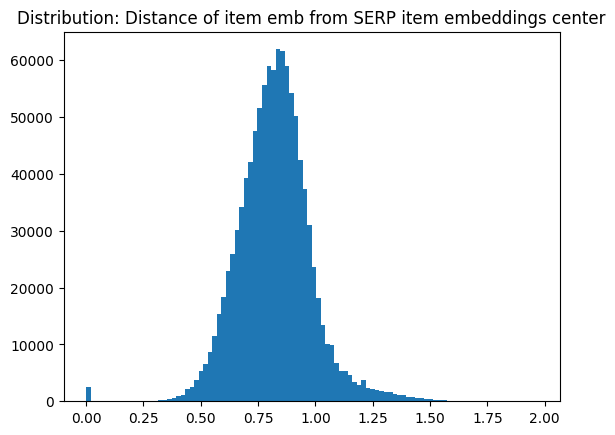

In [129]:
plt.hist(dist_from_serp, bins=100)
plt.title('Distribution: Distance of item emb from SERP item embeddings center')
plt.show()

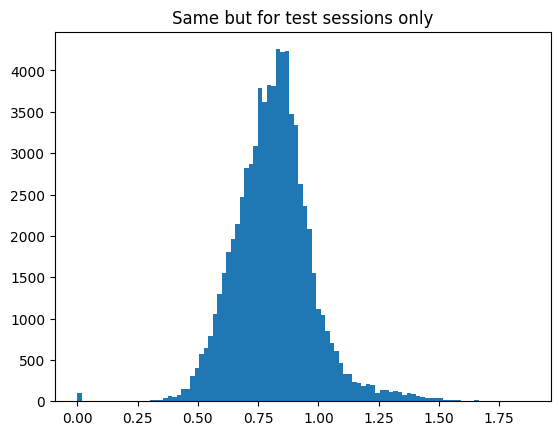

In [246]:
plt.hist(clicks_df.loc[clicks_df.session_id.isin(test_session_ids)].dist_from_serp, bins=100)
plt.title('Same but for test sessions only')
plt.show()

In [155]:
clicks_df['item_number']=clicks_df.item_id.map(lambda x: item_dict[int(x)] if int(x) in item_dict.keys() else -1)

In [186]:
session_df.loc[session_df.session_id==100083]

,length,frequency,no_categories,target_category,target,session_id,hit,mrr
5,3,269.0,1,False,23671,100083,False,0.0
6,1,502.0,1,True,36257,100083,True,0.3333333432674408
7,2,391.0,1,True,42615,100083,False,0.0


In [191]:
clicks_df.loc[clicks_df.session_id==100083]

,session_id,userId,item_id,timeframe,eventdate,query_id,serp,serp_pos,serp_len,dist_from_serp,item_number
304116,100083,NaN,376301,11074,2016-05-26,617707.0,"82598,39360,32775,176612,10557,33037,27802,155...",0.122050,189.0,1.083192,38882
304117,100083,NaN,181526,68526,2016-05-26,617707.0,"82598,39360,32775,176612,10557,33037,27802,155...",0.049634,189.0,0.923520,36257
304118,100083,NaN,387877,146509,2016-05-26,617707.0,"82598,39360,32775,176612,10557,33037,27802,155...",NaN,189.0,1.092544,42615
304119,100083,NaN,12459,376339,2016-05-26,737542.0,"1646,129592,9125,31613,16335,9126,83278,83280,...",0.061086,136.0,0.792657,23671


In [190]:
clicks_df.serp_pos=clicks_df.serp_pos.map(lambda x: x if x>=0 else np.nan)

In [157]:
#clicks_df.to_csv('../datasets/diginetica/clicks_df.csv')

In [20]:
clicks_df=pd.read_csv('../datasets/diginetica/clicks_df.csv').drop(columns='Unnamed: 0')

## correlations

In [22]:
corr_df=clicks_df[['session_id','item_id', 'serp_pos', 'dist_from_serp', 'item_number', 'serp_len']].merge(session_df, 
                                                                                       left_on=['session_id','item_number'], 
                                                                                       right_on=['session_id','target'])

In [23]:
corr_df

,session_id,item_id,serp_pos,dist_from_serp,item_number,serp_len,length,frequency,no_categories,target_category,target,hit,mrr
0,289,64068,-1.000000,1.109931,20071,19.0,1,10.0,1,False,20071,False,0.0
1,289,133346,-1.000000,1.130447,8762,19.0,2,20.0,2,False,8762,True,0.3333333432674408
2,289,438457,0.142643,0.683961,21566,198.0,5,18.4,4,True,21566,True,0.125
3,289,438457,0.142643,0.683961,21566,198.0,3,25.333333333333332,3,False,21566,False,0.0
4,289,198930,0.147147,0.538785,6381,198.0,4,20.5,4,True,6381,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91269,600404,1168,0.002602,0.759773,19589,180.0,1,45.0,1,True,19589,True,0.25
91270,600608,1813,0.036515,0.789202,5820,200.0,1,197.0,1,True,5820,True,0.0714285746216774
91271,600608,31789,0.037344,0.938444,3600,200.0,2,152.0,1,True,3600,True,0.10000000149011612
91272,600674,1152,0.025381,0.700841,10040,185.0,1,64.0,1,True,10040,False,0.0


In [24]:
from scipy.stats import pearsonr, spearmanr

In [25]:
corr_df.hit=corr_df.hit.map(lambda x: 1 if x else 0)
corr_df.mrr=corr_df.mrr.astype(float)

In [32]:
corr_df[['dist_from_serp','serp_pos','hit','mrr','serp_len']].dtypes

dist_from_serp    float64
serp_pos          float64
hit                 int64
mrr               float64
serp_len          float64
dtype: object

In [33]:
spearmanr(corr_df[['dist_from_serp','serp_pos','mrr','serp_len']].dropna(), 
     #     corr_df[['dist_from_serp','serp_pos','hit','mrr','serp_len']].dropna(),
          )

SignificanceResult(statistic=array([[ 1.        , -0.17637168,  0.15382035,  0.19972637],
       [-0.17637168,  1.        ,  0.12060617,  0.04844716],
       [ 0.15382035,  0.12060617,  1.        , -0.05057548],
       [ 0.19972637,  0.04844716, -0.05057548,  1.        ]]), pvalue=array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 4.37983404e-289,
        5.73132069e-048],
       [0.00000000e+000, 4.37983404e-289, 0.00000000e+000,
        4.03576181e-052],
       [0.00000000e+000, 5.73132069e-048, 4.03576181e-052,
        0.00000000e+000]]))

## center/span of item embeddings

In [23]:
# average center of embb space
items_center=np.average(items_embeddings, axis=0)

In [27]:
print('Max distnace between any two items: ', np.linalg.norm(np.max(items_embeddings, axis=0) - np.min(items_embeddings, axis=0)))

Max distnace between any two items:  7.0398483


## SERP vs Target clusters

In [228]:
def is_search_query(qid):
    st=qu_df.loc[qu_df.query_id==qid]['searchstring.tokens']
    if st.shape[0]!=1:
        return False
    st=st.item()
    if isinstance(st, float):
        return False
    return True

In [ ]:
search_query_dict={}
for qid in (clicks_df.query_id.unique()):#, total=clicks_df.query_id.nunique()):
    search_query_dict[qid]=is_search_query(qid)

sq_idxs=clicks_df.query_id.map(lambda x: x if np.isnan(x) else search_query_dict[x])

In [278]:
clicks_df['search_query']=sq_idxs
clicks_df['serp_abs_pos']=(clicks_df.serp_pos*clicks_df.serp_len).round()

In [253]:
clicks_df.head()

,session_id,userId,item_id,timeframe,eventdate,query_id,serp,serp_pos,serp_len,dist_from_serp,item_number,no_clusters_serp,target_cluster_proportion,serp_abs_pos
0,1,NaN,9654,75848,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.065199,199.0,0.976442,1890,6.0,0.892216,13.0
1,1,NaN,33043,173912,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.093988,199.0,0.819720,2460,6.0,0.892216,19.0
2,1,NaN,32118,243569,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.062659,199.0,0.786291,2558,6.0,0.892216,12.0
3,1,NaN,12352,329870,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.132091,199.0,0.881767,3012,6.0,0.892216,26.0
4,1,NaN,35077,390072,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.136325,199.0,0.867209,8171,6.0,0.892216,27.0


In [51]:
clicks_df.serp_pos=clicks_df.serp_pos.map(lambda x: np.nan if x==-1 else x)

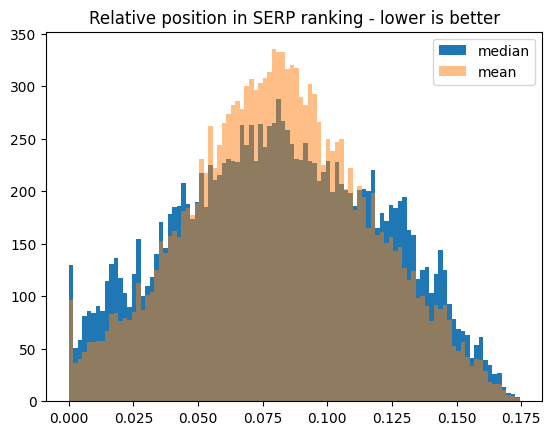

In [259]:
plt.hist(clicks_df[['session_id','serp_pos']].loc[clicks_df.session_id.isin(test_session_ids)]\
         .dropna().groupby('session_id').median('serp_pos').serp_pos, bins=100, label='median')
plt.hist(clicks_df[['session_id','serp_pos']].loc[clicks_df.session_id.isin(test_session_ids)]\
         .dropna().groupby('session_id').mean('serp_pos').serp_pos, bins=100, alpha=0.5, label='mean')
plt.title('Relative position in SERP ranking - lower is better')
plt.legend()
plt.show()

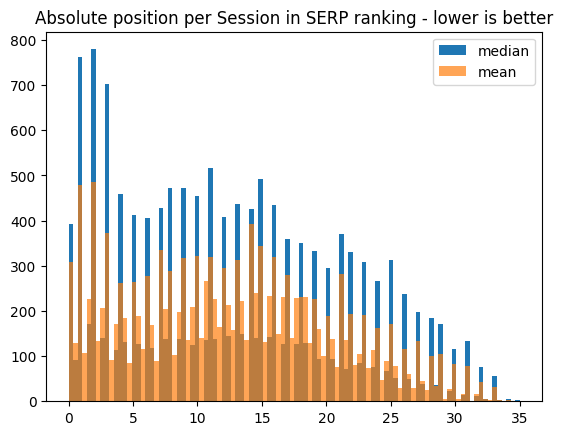

In [262]:
plt.hist(clicks_df[['session_id','serp_abs_pos']].loc[clicks_df.session_id.isin(test_session_ids)]\
         .dropna().groupby('session_id').median('serp_abs_pos').serp_abs_pos, bins=100, label='median')
plt.hist(clicks_df[['session_id','serp_abs_pos']].loc[clicks_df.session_id.isin(test_session_ids)]\
         .dropna().groupby('session_id').mean('serp_abs_pos').serp_abs_pos, bins=100, alpha=0.7, label='mean')
plt.title('Absolute position per Session in SERP ranking - lower is better')
plt.legend()
plt.show()

### seperate search queries

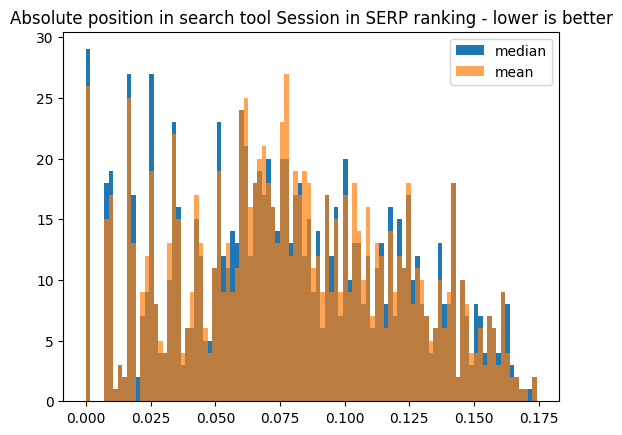

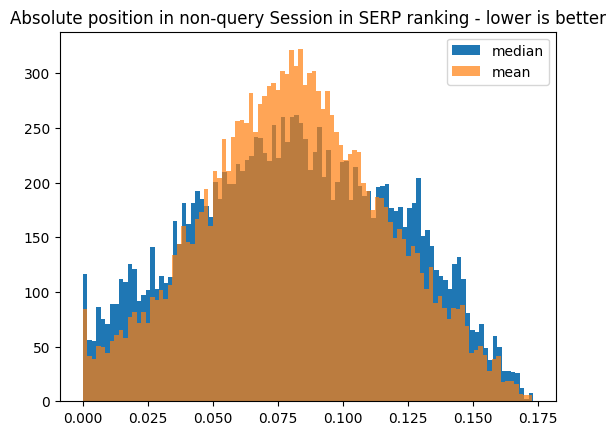

In [283]:
plt.hist(clicks_df[['session_id','serp_pos']].loc[(clicks_df.session_id.isin(test_session_ids))
                                                      &(clicks_df.search_query)]\
         .dropna().groupby('session_id').median('serp_pos').serp_pos, bins=100, label='median')
plt.hist(clicks_df[['session_id','serp_pos']].loc[(clicks_df.session_id.isin(test_session_ids))
                                                      &(clicks_df.search_query)]\
         .dropna().groupby('session_id').mean('serp_pos').serp_pos, bins=100, alpha=0.7, label='mean')
plt.title('Absolute position in search tool Session in SERP ranking - lower is better')
plt.legend()
plt.show()

plt.hist(clicks_df[['session_id','serp_pos']].loc[(clicks_df.session_id.isin(test_session_ids))
                                                      &(clicks_df.search_query!=True)]\
         .dropna().groupby('session_id').median('serp_pos').serp_pos, bins=100, label='median')
plt.hist(clicks_df[['session_id','serp_pos']].loc[(clicks_df.session_id.isin(test_session_ids))
                                                      &(clicks_df.search_query!=True)]\
         .dropna().groupby('session_id').mean('serp_pos').serp_pos, bins=100, alpha=0.7, label='mean')
plt.title('Absolute position in non-query Session in SERP ranking - lower is better')
plt.legend()
plt.show()

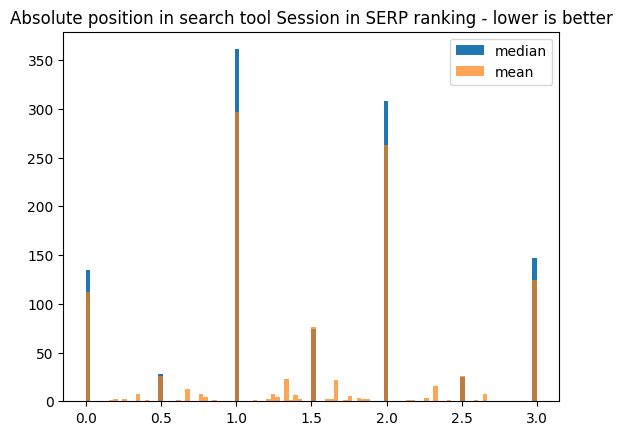

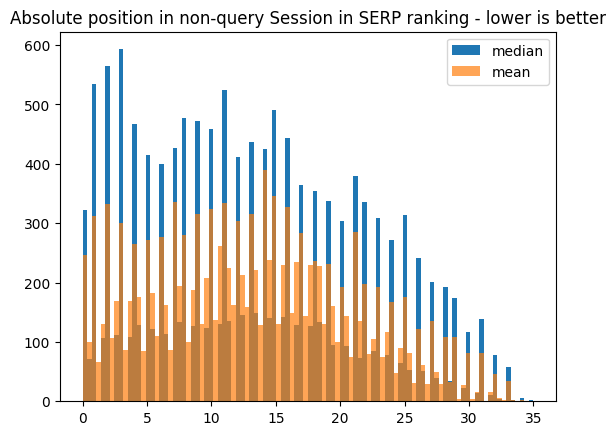

In [282]:
plt.hist(clicks_df[['session_id','serp_abs_pos']].loc[(clicks_df.session_id.isin(test_session_ids))
                                                      &(clicks_df.search_query)]\
         .dropna().groupby('session_id').median('serp_abs_pos').serp_abs_pos, bins=100, label='median')
plt.hist(clicks_df[['session_id','serp_abs_pos']].loc[(clicks_df.session_id.isin(test_session_ids))
                                                      &(clicks_df.search_query)]\
         .dropna().groupby('session_id').mean('serp_abs_pos').serp_abs_pos, bins=100, alpha=0.7, label='mean')
plt.title('Absolute position in search tool Session in SERP ranking - lower is better')
plt.legend()
plt.show()

plt.hist(clicks_df[['session_id','serp_abs_pos']].loc[(clicks_df.session_id.isin(test_session_ids))
                                                      &(clicks_df.search_query!=True)]\
         .dropna().groupby('session_id').median('serp_abs_pos').serp_abs_pos, bins=100, label='median')
plt.hist(clicks_df[['session_id','serp_abs_pos']].loc[(clicks_df.session_id.isin(test_session_ids))
                                                      &(clicks_df.search_query!=True)]\
         .dropna().groupby('session_id').mean('serp_abs_pos').serp_abs_pos, bins=100, alpha=0.7, label='mean')
plt.title('Absolute position in non-query Session in SERP ranking - lower is better')
plt.legend()
plt.show()

### distnace from SERP centre

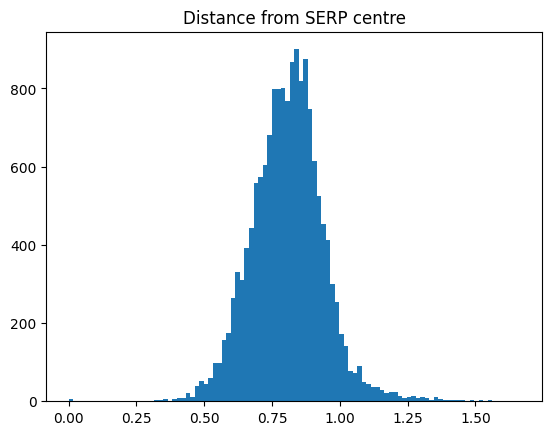

In [58]:
plt.hist(clicks_df[['session_id','dist_from_serp']].loc[clicks_df.session_id.isin(test_session_ids)]\
         .groupby('session_id').median('dist_from_serp').dist_from_serp, bins=100)
plt.title('Distance from SERP centre')
plt.show()

In [207]:
# ciekawe przypadki
# 2137, 10, 1488, 69


sample=clicks_df.iloc[1044]
sample

session_id                                                                 289
userId                                                                     NaN
item_id                                                                 125013
timeframe                                                                18301
eventdate                                                           2016-05-26
query_id                                                                 292.0
serp                         126860,791,82380,72561,72562,125013,10240,4204...
serp_pos                                                               0.04386
serp_len                                                                  19.0
dist_from_serp                                                        0.878109
item_number                                                              21553
no_clusters_serp                                                           8.0
target_cluster_proportion                           

In [208]:
fig = go.Figure()

embs=[]
labels=[]
for iid in sample.serp.split(','):
    try:
        embs.append(tsne_items_embeddings[item_dict[int(iid)]])
        labels.append(item_labels[item_dict[int(iid)]])
    except KeyError:
        continue

embs=np.array(embs)
labels=np.array(labels)
for label in set(labels):
    idxs=labels==label
    label_embedding=embs[idxs]
    fig.add_trace(go.Scatter(x=label_embedding[:,0], y=label_embedding[:,1], name=str(label), mode='markers'))

fig.add_trace(go.Scatter(x=[tsne_items_embeddings[item_dict[sample.item_id], 0]], 
                            y=[tsne_items_embeddings[item_dict[sample.item_id], 1]], 
                            name=f'target in {item_labels[item_dict[sample.item_id]]}', mode='markers', 
                            marker=dict(size=12,
                                    line=dict(width=2,
                                    color='DarkSlateGrey'))))


fig.update_layout(title=f'Single SERP items embeddings with GM clusters. Search Query = {is_search_query(sample.query_id)}',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.show()

### aggregate above info

In [ ]:
query_serp_clusters_dict={}
for _,r in tqdm(clicks_df[['query_id','serp']].drop_duplicates().iterrows()):
    labels=[]
    if not r.serp is np.nan:
        for iid in r.serp.split(','):
            try:
                labels.append(item_labels[item_dict[int(iid)]])
            except KeyError:
                continue
        query_serp_clusters_dict[r.query_id]=np.unique(labels, return_counts=True)

In [178]:
def get_serpXcluster_info(r):
    if r.item_number<0:
        return np.nan, np.nan
    try:
        vals,counts=query_serp_clusters_dict[r.query_id]
        no_vals=vals.shape[0]
        proportion=0
        if item_labels[r.item_number] in vals:
            i=vals.tolist().index(item_labels[r.item_number])
            proportion=counts[i]/sum(counts)
    except KeyError:
        return (np.nan, np.nan)
    return no_vals, proportion

In [179]:
pom=clicks_df.apply(lambda r: get_serpXcluster_info(r), axis=1)
clicks_df['no_clusters_serp']=[x[0] for x in pom]
clicks_df['target_cluster_proportion']=[x[1] for x in pom]
del pom

In [286]:
#clicks_df.to_csv('../datasets/diginetica/clicks_df.csv')

In [220]:
clicks_df.loc[(clicks_df.target_cluster_proportion>=0.7)
              &(clicks_df.session_id.isin(test_session_ids))].shape[0]/clicks_df.loc[clicks_df.session_id.isin(test_session_ids)].target_cluster_proportion.dropna().shape[0]

0.5213398091658616

In [240]:
clicks_df.query_id.unique()

array([890364.,  46555.,  46562., ..., 980490., 980493., 980503.])

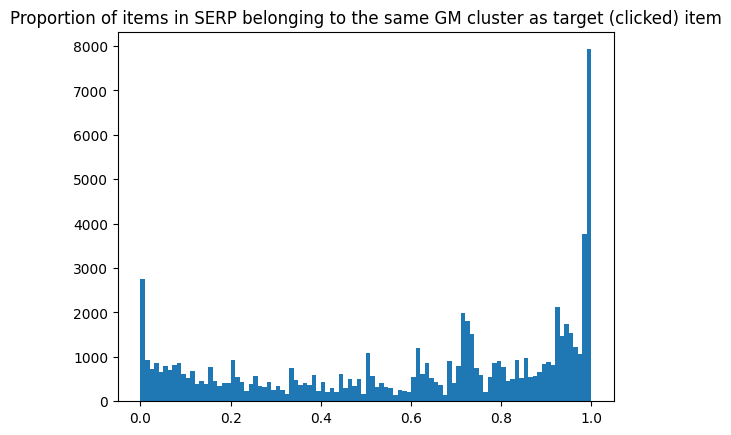

In [224]:
plt.hist(clicks_df.loc[clicks_df.session_id.isin(test_session_ids)].target_cluster_proportion.dropna(), bins=100)
plt.title('Proportion of items in SERP belonging to the same GM cluster as target (clicked) item')
plt.show()

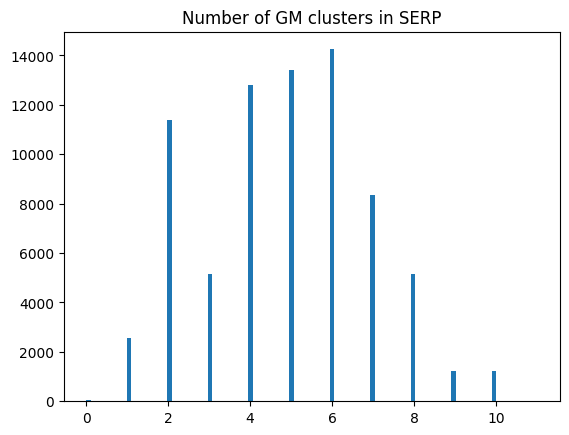

In [221]:
plt.hist(clicks_df.loc[clicks_df.session_id.isin(test_session_ids)].no_clusters_serp.dropna(), bins=100)
plt.title('Number of GM clusters in SERP')
plt.show()

## autoencoder on item embbedings

In [82]:
from torch import nn

In [86]:
class Encoder(nn.Module):
    def __init__(self):
        """Encoder.

        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(opt.hiddenSize, 32), 
            nn.Tanh(),
            nn.Linear(32, 8), 
            nn.Tanh(),
            nn.Linear(8, 2), 
            nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)

In [85]:
class Decoder(nn.Module):
    def __init__(self):
        """Decoder.

        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 8), 
            nn.Tanh(),
            nn.Linear(8, 32), 
            nn.Tanh(),
            nn.Linear(32, 100), 
            nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)

In [87]:
from torch import optim

In [129]:
class Autoencoder(pl.LightningModule):
    def __init__(
        self, lr
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = Encoder()
        self.decoder = Decoder()
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, opt.hiddenSize)
        self.loss=nn.MSELoss()
        self.lr=lr

    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """Given a batch of images, this function returns the reconstruction loss (MSE in our case)."""
        x, _ = batch  # We do not need the labels
        x_hat = self.forward(x)
        loss = self.loss(x, x_hat)
      #  loss = loss.mean()
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=5, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("val_loss", loss, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("test_loss", loss)

In [89]:
import torch.utils.data as data_utils


In [94]:
class ItemDataset(data_utils.Dataset):
    def __init__(self, X, Y):
        super().__init__()
        self.X=X
        self.Y=Y

    def __len__(self):
        return self.Y.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [95]:
train_idxs=np.random.randint(0, item_labels.shape[0], size=int(item_labels.shape[0]*0.8))
val_idxs=[x for x in range(item_labels.shape[0]) if not x in train_idxs]

items_train_dataloader=data_utils.DataLoader(ItemDataset(items_embeddings[train_idxs], item_labels[train_idxs]),
                                             batch_size=32, num_workers=os.cpu_count(),
                                             shuffle=True, drop_last=True)
items_val_dataloader=data_utils.DataLoader(ItemDataset(items_embeddings[val_idxs], item_labels[val_idxs]),
                                             batch_size=32, num_workers=os.cpu_count(),
                                             )

In [99]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint


In [142]:
trainer=pl.Trainer( accelerator="auto",
        devices=1,
        max_epochs=500,
        callbacks=[
            ModelCheckpoint(monitor="val_loss", mode="min"),
            LearningRateMonitor("epoch"),
            EarlyStopping(
                monitor="val_loss", patience=opt.patience, mode="min", check_finite=True
            ),
        ],
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [140]:
autoencoder=Autoencoder(lr=1e-2)

In [141]:
with torch.no_grad():
    # Initialize parameters
    for name, p in autoencoder.named_parameters():
        if "weight" in name:
            #p.normal_(0, 0.5)
            nn.init.xavier_normal_(p)
        elif "bias" in name:
            p.normal_(0, 1e-2)
           # nn.init.xavier_normal_(p)
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

In [143]:
trainer.fit(autoencoder, items_train_dataloader, items_val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes | Out sizes
-----------------------------------------------------------
0 | encoder | Encoder | 3.5 K  | [2, 100] | [2, 2]   
1 | decoder | Decoder | 3.6 K  | [2, 2]   | [2, 100] 
2 | loss    | MSELoss | 0      | ?        | ?        
-----------------------------------------------------------
7.1 K     Trainable params
0         Non-trainable params
7.1 K     Total params
0.029     Total estimated model params size (MB)


Epoch 38: 100%|██████████| 1077/1077 [00:04<00:00, 250.01it/s, v_num=632, val_loss=0.00844]

/home/kacper/anaconda3/envs/gpu_torch/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



In [146]:
ae_item_embeddings=autoencoder.encoder(torch.tensor(items_embeddings, device=autoencoder.device)).cpu().detach().numpy()

In [ ]:
fig = go.Figure()

for label in np.unique(item_labels):
    label_embedding=ae_item_embeddings[item_labels==label]
    fig.add_trace(go.Scatter(x=label_embedding[:,0], y=label_embedding[:,1], name=str(label), mode='markers'))



fig.update_layout(title='AutoEncoder reduced items embeddings with GM',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.write_html(f'./images/items_AE_{gm.n_components}_{gm.init_params}_{opt.dataset}_{opt.hiddenSize}_{global_run_id.split("-")[-1]}.html')
fig.show()

In [151]:
del items_train_dataloader
del items_val_dataloader
del autoencoder
del trainer
del ae_item_embeddings

## more